| Task                                                         | Status (Done/Not Done) | Comments/Notes                                   |
|--------------------------------------------------------------|-------------------------|-------------------------------------------------|
| Data Preprocessing                                     | Done                    | Loaded and preprocessed images from JSON.       |
| Scaling and Resizing                                    | Done                    | Images resized to (224, 224) and scaled (normalized). |
| Image Augmentation                                      | Done                    | Implemented using ImageDataGenerator.         |
| Train and test data handled correctly                   | Done                    | Data split into training, validation, and test sets. |
| Gaussian Blur, Histogram Equalization, and Intensity thresholds | Not Done                | Not implemented in the provided code.           |
| Model Trained                                           | Done                    | Model trained with fit() method; training time not specified. |
| AUC and Confusion Matrix Computed                      | Done                    | Confusion matrix computed and plotted.          |
| Overfitting/Underfitting checked and handled            | Partially Done          | Early stopping used; check for overfitting through validation accuracy/loss plots. |


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, LeakyReLU, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
from collections import Counter

In [2]:
photo_data = pd.read_json('photos.json',lines=True) #Loading the JSON file

In [5]:
label_distribution = Counter(photo_data['label'])
print("Original Label Distribution:", label_distribution)

Original Label Distribution: Counter({'food': 108152, 'inside': 56031, 'outside': 18569, 'drink': 15670, 'menu': 1678})


In [6]:
target_size=1678 #Taking the count from the class with least data
#Handling class imbalance
sampled_data = photo_data.groupby('label', group_keys=False).apply(lambda x: x.sample(n=target_size, replace=True, random_state=42) 
if len(x)<target_size else x.sample(n=target_size, random_state=42)).sample(frac=1, random_state=42).reset_index(drop=True)

C:\Users\jini\AppData\Local\Temp\ipykernel_9428\2608709244.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = photo_data.groupby('label', group_keys=False).apply(lambda x: x.sample(n=target_size, replace=True, random_state=42)


In [7]:
new_label_distribution = Counter(sampled_data['label']) #Class distribution after handling class imbalance
print("Current Label Distribution:", new_label_distribution)

Current Label Distribution: Counter({'outside': 1678, 'food': 1678, 'menu': 1678, 'drink': 1678, 'inside': 1678})


In [20]:
images_array, labels_array = load_and_preprocess_images(sampled_data)
print("Number of images loaded:", len(images_array))

Error loading image photos\ki0z-58NcxLiwB2lFerEMA.jpg: [Errno 2] No such file or directory: 'photos\\ki0z-58NcxLiwB2lFerEMA.jpg'
Error loading image photos\vejqfjsReeC16GzSeUIjBg.jpg: [Errno 2] No such file or directory: 'photos\\vejqfjsReeC16GzSeUIjBg.jpg'
Error loading image photos\c2xMnCb40P4szjnHQW7RHg.jpg: [Errno 2] No such file or directory: 'photos\\c2xMnCb40P4szjnHQW7RHg.jpg'
Error loading image photos\YQP1MseLyRjPOQ66pdi2uw.jpg: [Errno 2] No such file or directory: 'photos\\YQP1MseLyRjPOQ66pdi2uw.jpg'
Error loading image photos\JGL06eKEL5cYETc3wis1Eg.jpg: [Errno 2] No such file or directory: 'photos\\JGL06eKEL5cYETc3wis1Eg.jpg'
Error loading image photos\Y38EybhxeX-PHVHPKieMdQ.jpg: [Errno 2] No such file or directory: 'photos\\Y38EybhxeX-PHVHPKieMdQ.jpg'
Error loading image photos\qXedooX3y7RVx5ufaloyfQ.jpg: [Errno 2] No such file or directory: 'photos\\qXedooX3y7RVx5ufaloyfQ.jpg'
Error loading image photos\H8L9pWB_fGsSwg7AE5Vq4Q.jpg: [Errno 2] No such file or directory: 'phot

***Image Preprocessing***

In [19]:
def load_and_preprocess_images(sampled_data, img_size=(224, 224)):
    images = []
    labels = []
    for _, row in sampled_data.iterrows():
        img_path = os.path.join('photos', f"{row['photo_id']}.jpg")
        try:
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(row['label'])
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels)


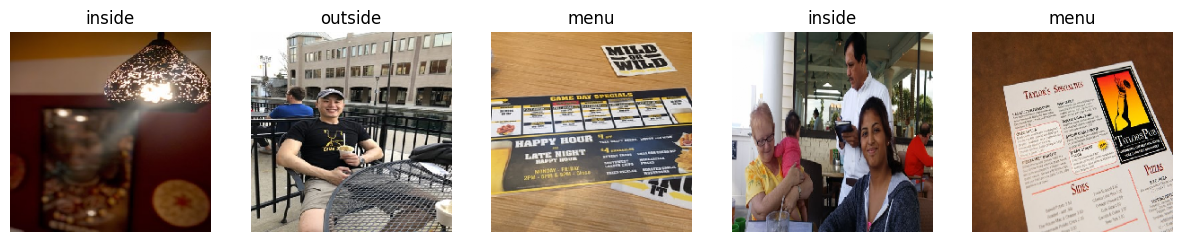

In [23]:
if len(images_array) > 0:
    num_images = 5
    random_indices = np.random.choice(len(images_array), size=num_images, replace=False)
    plt.figure(figsize=(15, 10))
    for i, index in enumerate(random_indices):  # Displaying a few loaded images with their labels
        img = images_array[index]
        label = labels_array[index]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()
else:
    print("No images available to display.")


In [25]:
from tensorflow.keras.utils import to_categorical

label_encoder=LabelEncoder()
encoded_labels=label_encoder.fit_transform(labels_array) #Converting labels to numeric
one_hot_labels=to_categorical(encoded_labels) #One-hot-encoding the labels

In [26]:
class_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
print("Class Mapping:", class_mapping)

Class Mapping: {0: 'drink', 1: 'food', 2: 'inside', 3: 'menu', 4: 'outside'}


In [27]:
X_train,X_temp,y_train,y_temp=train_test_split(images_array,one_hot_labels,test_size=0.2,random_state=42) #Train-Temp split
X_val,X_test,y_val,y_test=train_test_split(X_temp,y_temp,test_size=0.5,random_state=42) #Further splitting temp to val and test set

print("Training set shape:", X_train.shape,y_train.shape)
print("Validation set shape:", X_val.shape,y_val.shape)
print("Testing set shape:", X_test.shape,y_test.shape)

Training set shape: (1054, 224, 224, 3) (1054, 5)
Validation set shape: (132, 224, 224, 3) (132, 5)
Testing set shape: (132, 224, 224, 3) (132, 5)


In [28]:
# Set up data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
datagen.fit(X_train)

In [29]:
# Load EfficientNetB0 with pre-trained weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [30]:
# Unfreeze some layers in EfficientNetB0 for fine-tuning
for layer in base_model.layers[-100:]:
    layer.trainable = True

In [32]:
from tensorflow.keras.models import Sequential
# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(512),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    BatchNormalization(),
    Dense(256),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    BatchNormalization(),
    Dense(one_hot_labels.shape[1], activation='softmax')
])

c:\Users\jini\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [33]:
# Compile model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [34]:
# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [38]:
# Train the model using the data generator
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[early_stopping]
)


Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 188s 6s/step - accuracy: 0.7619 - loss: 0.6788 - val_accuracy: 0.5152 - val_loss: 1.2189
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 195s 6s/step - accuracy: 0.7713 - loss: 0.6508 - val_accuracy: 0.5909 - val_loss: 0.9854
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 179s 5s/step - accuracy: 0.7862 - loss: 0.6057 - val_accuracy: 0.6894 - val_loss: 0.8179
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 170s 5s/step - accuracy: 0.8083 - loss: 0.5485 - val_accuracy: 0.7652 - val_loss: 0.6743
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 170s 5s/step - accuracy: 0.7817 - loss: 0.5832 - val_accuracy: 0.8258 - val_loss: 0.5770
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 169s 5s/step - accuracy: 0.7856 - loss: 0.6312 - val_accuracy: 0.8182 - val_loss: 0.5460
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 163s 5s/step - accuracy: 0.8087 - loss: 0.5265 - val_accuracy: 0.8182 - val_loss: 0.4921
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 161s 5s/step - accuracy: 0.8500 - loss: 0.4457 - val_accuracy: 0.8333 - v

In [39]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 692ms/step - accuracy: 0.8987 - loss: 0.3230
Test Loss: 0.3363495171070099
Test Accuracy: 0.8939393758773804


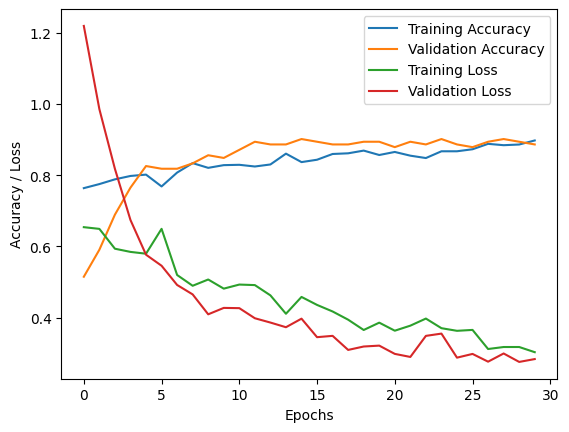

In [40]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.show()

In [41]:
# Generate predictions on the test set
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step 


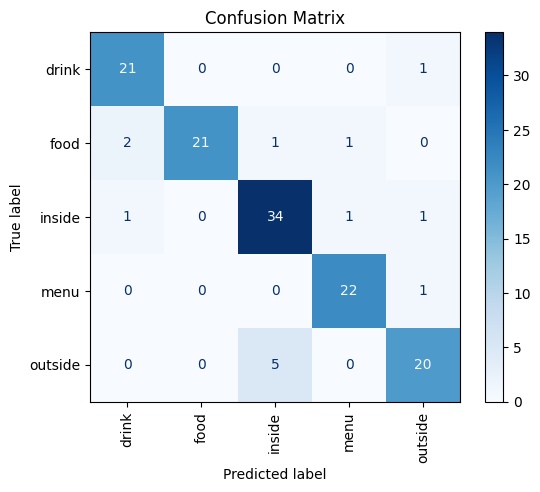

In [42]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()

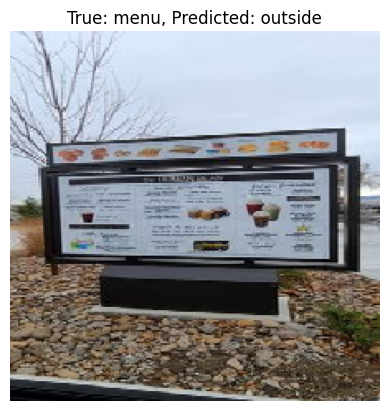

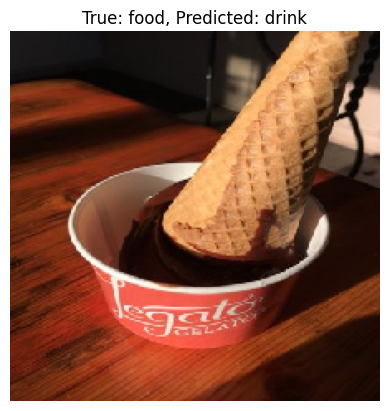

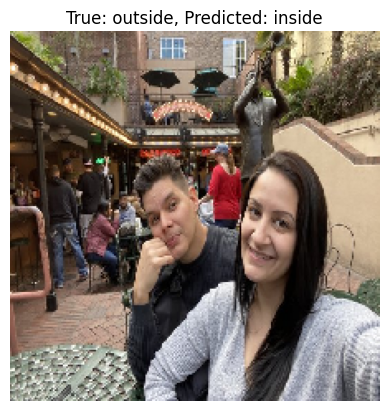

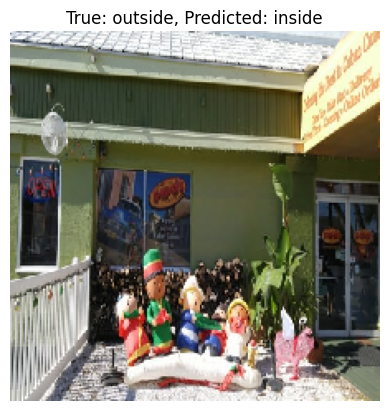

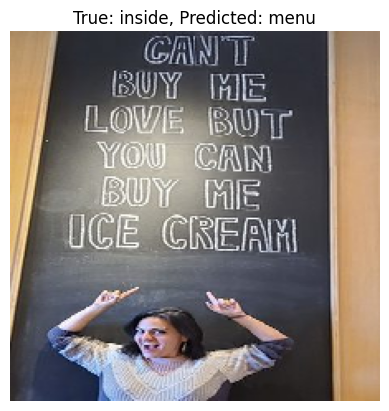

In [43]:
misclassified_indices = np.where(predicted_labels != true_labels)[0]
for idx in misclassified_indices[:5]:  
    img = X_test[idx]  
    true_label = label_encoder.inverse_transform([true_labels[idx]])[0] 
    pred_label = label_encoder.inverse_transform([predicted_labels[idx]])[0]  
    
    plt.imshow(img)
    plt.title(f"True: {true_label}, Predicted: {pred_label}")
    plt.axis('off')
    plt.show()

Correctly Classified Images:


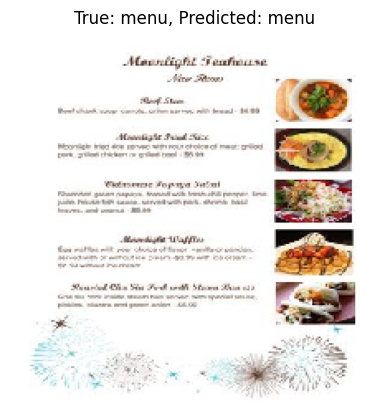

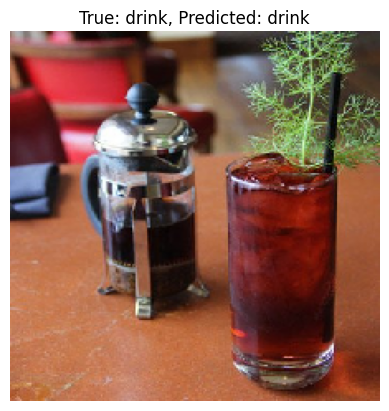

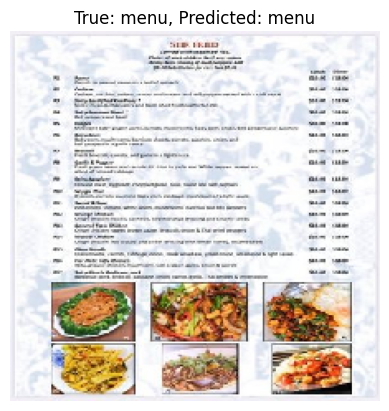

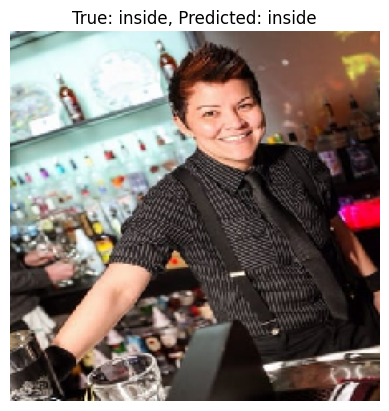

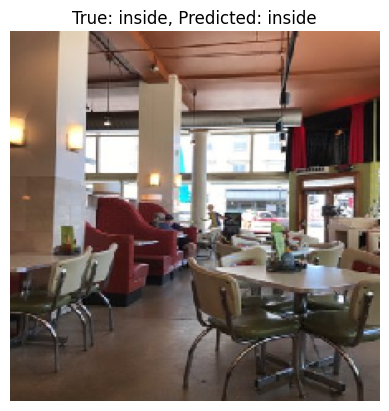

: 

In [44]:
correctly_classified_indices = np.where(predicted_labels == true_labels)[0]

print("Correctly Classified Images:")
for idx in correctly_classified_indices[:5]: 
    img = X_test[idx]
    true_label = label_encoder.inverse_transform([true_labels[idx]])[0]
    pred_label = label_encoder.inverse_transform([predicted_labels[idx]])[0]  
    
    plt.imshow(img)
    plt.title(f"True: {true_label}, Predicted: {pred_label}")
    plt.axis('off')
    plt.show()